<a href="https://colab.research.google.com/github/jonathancagua/IA-PINN/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

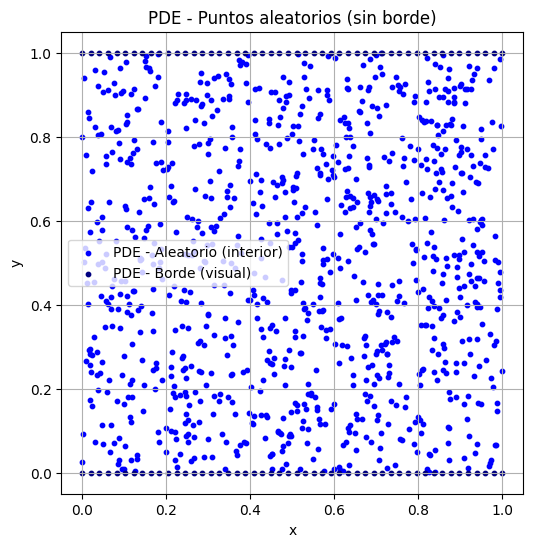

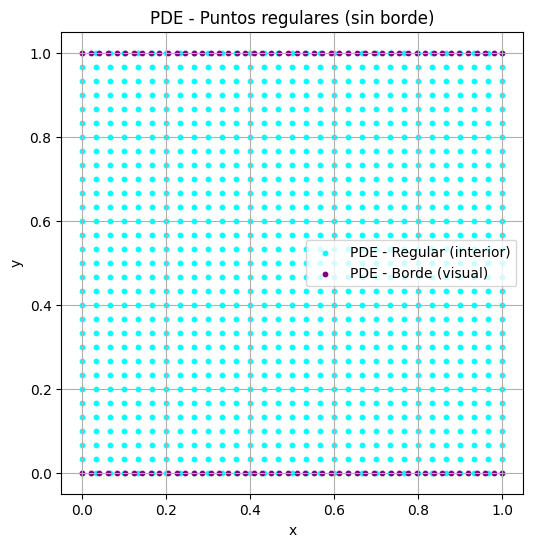

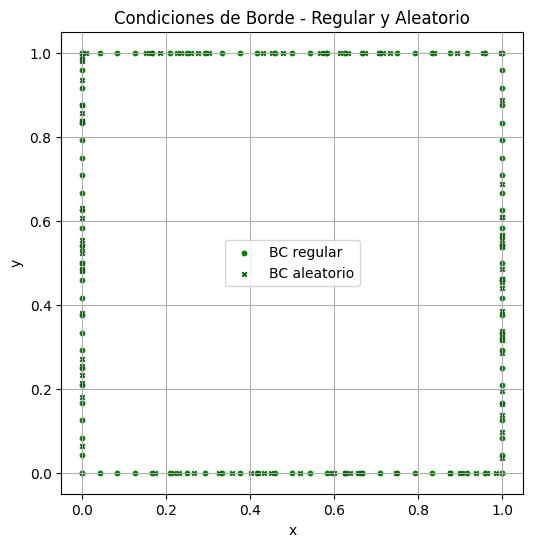

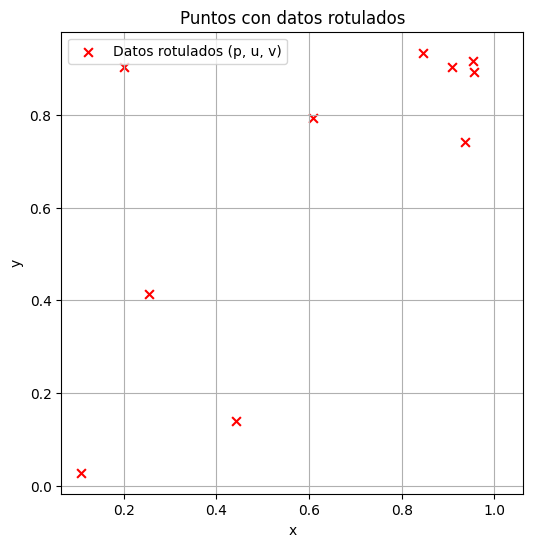


Valores interpolados en puntos rotulados:
     x      y          p          u          v
 0.108  0.028     0.0030    -0.1111    -0.0263
 0.609  0.793     0.0008    -0.0069     0.0195
 0.255  0.414    -0.0151    -0.0003     0.0184
 0.200  0.902    -0.0069    -0.0004    -0.0084
 0.953  0.917    -0.0791     0.4704     0.0192
 0.909  0.904    -0.0897     0.1718     0.0038
 0.442  0.139    -0.0474     0.1452     0.1238
 0.847  0.934    -0.0455    -0.0052     0.1093
 0.937  0.742    -0.0622    -0.0287     0.2019
 0.956  0.893    -0.1662    -0.0145     0.1383


In [1]:
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/pressure.mat
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/velocity.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Cargar datos
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')

p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']

ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# Parámetro pequeño para evitar bordes en PDE
eps = 1e-5

# Cantidades de puntos
Npde = 1000
Nbc = 100
Ndata = 10
Nbc_per_edge = Nbc // 4

# --- 1. PUNTOS DE COLOCACIÓN PARA PDE ---

x_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)
y_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)

n_side = int(np.sqrt(Npde))
x_grid = np.linspace(eps, 1.0 - eps, n_side)
y_grid = np.linspace(eps, 1.0 - eps, n_side)
x_pde_reg, y_pde_reg = np.meshgrid(x_grid, y_grid)
x_pde_reg = x_pde_reg.flatten()
y_pde_reg = y_pde_reg.flatten()

N_border = 50
x_pde_border = np.linspace(0, 1, N_border)
y_pde_border_top = np.ones(N_border) * 1.0
y_pde_border_bottom = np.zeros(N_border)
x_pde_border_combined = np.concatenate([x_pde_border, x_pde_border])
y_pde_border_combined = np.concatenate([y_pde_border_bottom, y_pde_border_top])

# --- 2. PUNTOS DE COLOCACIÓN PARA BC ---

x_bc_top_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_top_reg = np.ones_like(x_bc_top_reg)
x_bc_bottom_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_bottom_reg = np.zeros_like(x_bc_bottom_reg)
y_bc_left_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_left_reg = np.zeros_like(y_bc_left_reg)
y_bc_right_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_right_reg = np.ones_like(y_bc_right_reg)

x_bc_top_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_top_rand = np.ones_like(x_bc_top_rand)
x_bc_bottom_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_bottom_rand = np.zeros_like(x_bc_bottom_rand)
y_bc_left_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_left_rand = np.zeros_like(y_bc_left_rand)
y_bc_right_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_right_rand = np.ones_like(y_bc_right_rand)

# --- 3. PUNTOS ROTULADOS (mediciones) ---

x_data = np.random.uniform(0, 1, Ndata)
y_data = np.random.uniform(0, 1, Ndata)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# --- GRÁFICAS ---

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_rand, y_pde_rand, s=10, c='blue', label='PDE - Aleatorio (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='navy', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos aleatorios (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_reg, y_pde_reg, s=10, c='cyan', label='PDE - Regular (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='purple', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos regulares (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(np.concatenate([x_bc_top_reg, x_bc_bottom_reg, x_bc_left_reg, x_bc_right_reg]),
            np.concatenate([y_bc_top_reg, y_bc_bottom_reg, y_bc_left_reg, y_bc_right_reg]),
            s=10, c='green', label='BC regular')
plt.scatter(np.concatenate([x_bc_top_rand, x_bc_bottom_rand, x_bc_left_rand, x_bc_right_rand]),
            np.concatenate([y_bc_top_rand, y_bc_bottom_rand, y_bc_left_rand, y_bc_right_rand]),
            s=10, c='darkgreen', marker='x', label='BC aleatorio')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Condiciones de Borde - Regular y Aleatorio')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_data, y_data, s=40, c='red', marker='x', label='Datos rotulados (p, u, v)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos con datos rotulados')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

print("\nValores interpolados en puntos rotulados:")
print(f"{'x':>6} {'y':>6} {'p':>10} {'u':>10} {'v':>10}")
for x, y, p_val, u_val, v_val in zip(x_data, y_data, p_data, u_data, v_data):
    print(f"{x:6.3f} {y:6.3f} {p_val:10.4f} {u_val:10.4f} {v_val:10.4f}")



Los puntos para la PDE no deben incluirse en las fronteras del dominio, ya que las ecuaciones diferenciales se evalúan solo en el interior, mientras que las condiciones de frontera se tratan por separado. Incluir puntos en el borde mezclaría dos tipos de información que deben manejarse con funciones de pérdida distintas.

#TP2
## PUNTO 1 - 2

Epoch 0, Total Loss: 2.3340e-01
  PDE -> r1: 9.87e-03, r2: 6.12e-04, r3: 3.20e-02
  BC Loss: 1.9095e-01, Pressure Loss (x=0,y=0): 0.0000e+00
Epoch 500, Total Loss: 8.6652e-02
  PDE -> r1: 1.31e-04, r2: 1.49e-04, r3: 1.36e-03
  BC Loss: 8.5007e-02, Pressure Loss (x=0,y=0): 2.7487e-10
Epoch 1000, Total Loss: 5.3345e-02
  PDE -> r1: 4.00e-04, r2: 1.29e-04, r3: 1.56e-03
  BC Loss: 5.1252e-02, Pressure Loss (x=0,y=0): 6.4543e-06
Epoch 1500, Total Loss: 4.8197e-02
  PDE -> r1: 5.32e-04, r2: 2.03e-04, r3: 1.21e-03
  BC Loss: 4.6248e-02, Pressure Loss (x=0,y=0): 4.8516e-08
Epoch 2000, Total Loss: 4.3948e-02
  PDE -> r1: 7.10e-04, r2: 3.53e-04, r3: 9.69e-04
  BC Loss: 4.1915e-02, Pressure Loss (x=0,y=0): 3.4346e-09
Epoch 2500, Total Loss: 4.2022e-02
  PDE -> r1: 9.19e-04, r2: 5.38e-04, r3: 7.22e-04
  BC Loss: 3.7539e-02, Pressure Loss (x=0,y=0): 2.3051e-03
Epoch 3000, Total Loss: 3.6092e-02
  PDE -> r1: 1.06e-03, r2: 7.30e-04, r3: 5.57e-04
  BC Loss: 3.3743e-02, Pressure Loss (x=0,y=0): 9.4661e

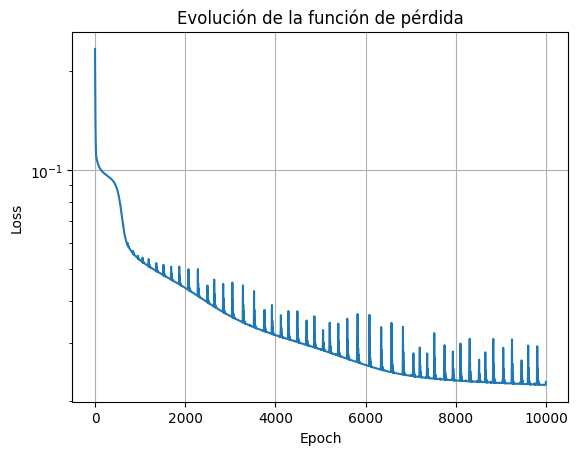

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# --- Configuración general ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# --- Cargar datos del .mat ---
data_p = loadmat('pressure.mat')['p']
data_u = loadmat('velocity.mat')['u']
data_v = loadmat('velocity.mat')['v']
x = loadmat('velocity.mat')['x'].squeeze()
y = loadmat('velocity.mat')['y'].squeeze()

ny, nx = data_p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x_vals, y_vals)

# --- Crear dataset para PDE (muestreo aleatorio) ---
Npde = 10000
X_pde = np.random.uniform(0, 1, (Npde, 2))
X_pde_torch = torch.tensor(X_pde, dtype=torch.float32, requires_grad=True).to(device)

# --- Crear dataset para condiciones de borde ---
Nbc = 1000
N_per_edge = Nbc // 4

# Fronteras
x_bc_top = np.random.uniform(0, 1, (N_per_edge, 1))
y_bc_top = np.ones_like(x_bc_top)
x_bc_bottom = np.random.uniform(0, 1, (N_per_edge, 1))
y_bc_bottom = np.zeros_like(x_bc_bottom)
y_bc_left = np.random.uniform(0, 1, (N_per_edge, 1))
x_bc_left = np.zeros_like(y_bc_left)
y_bc_right = np.random.uniform(0, 1, (N_per_edge, 1))
x_bc_right = np.ones_like(y_bc_right)

X_bc = np.vstack([
    np.hstack([x_bc_top, y_bc_top]),
    np.hstack([x_bc_bottom, y_bc_bottom]),
    np.hstack([x_bc_left, y_bc_left]),
    np.hstack([x_bc_right, y_bc_right])
])
X_bc_torch = torch.tensor(X_bc, dtype=torch.float32).to(device)

y_bc_u = torch.cat([
    torch.ones((N_per_edge, 1)),         # top u=1
    torch.zeros((3 * N_per_edge, 1))     # other u=0
], dim=0).to(device)

y_bc_v = torch.zeros((Nbc, 1)).to(device)

# --- Red neuronal PINN ---
class PINN_NavierStokes(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [2, 64, 64, 64, 64, 3]
        self.activation = nn.Tanh()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for i in range(len(self.net)-1):
            x = self.activation(self.net[i](x))
        return self.net[-1](x)

def init_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

def compute_residuals(model, X):
    X.requires_grad_(True)
    output = model(X)
    p, u, v = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    grads = lambda f, x: torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f), create_graph=True)[0]
    u_x, u_y = grads(u, X)[:, 0:1], grads(u, X)[:, 1:2]
    v_x, v_y = grads(v, X)[:, 0:1], grads(v, X)[:, 1:2]
    p_x, p_y = grads(p, X)[:, 0:1], grads(p, X)[:, 1:2]

    nu = 0.01
    u_xx = grads(u_x, X)[:, 0:1]
    u_yy = grads(u_y, X)[:, 1:2]
    v_xx = grads(v_x, X)[:, 0:1]
    v_yy = grads(v_y, X)[:, 1:2]

    r1 = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    r2 = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
    r3 = u_x + v_y
    return r1, r2, r3

# --- Entrenamiento ---
model = PINN_NavierStokes().to(device)
init_xavier(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

loss_history = []

for epoch in range(10000):
    optimizer.zero_grad()
    r1, r2, r3 = compute_residuals(model, X_pde_torch)
    loss_r1 = loss_fn(r1, torch.zeros_like(r1))
    loss_r2 = loss_fn(r2, torch.zeros_like(r2))
    loss_r3 = loss_fn(r3, torch.zeros_like(r3))
    loss_pde = loss_r1 + loss_r2 + loss_r3

    bc_pred = model(X_bc_torch)
    loss_bc = loss_fn(bc_pred[:, 1:2], y_bc_u) + loss_fn(bc_pred[:, 2:3], y_bc_v)

    x_p0 = torch.tensor([[0.0, 0.0]], dtype=torch.float32).to(device)
    p0_pred = model(x_p0)[:, 0:1]
    loss_p = 1e3 * loss_fn(p0_pred, torch.zeros_like(p0_pred))  # ponderado

    loss = loss_pde + loss_bc + loss_p
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.4e}")
        print(f"  PDE -> r1: {loss_r1.item():.2e}, r2: {loss_r2.item():.2e}, r3: {loss_r3.item():.2e}")
        print(f"  BC Loss: {loss_bc.item():.4e}, Pressure Loss (x=0,y=0): {loss_p.item():.4e}")

# --- Gráfico pérdida ---
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolución de la función de pérdida")
plt.grid()
plt.show()

## PUNTO 3

In [3]:
xy_eval = np.stack([x, y], axis=-1)
xy_eval_tensor = torch.tensor(xy_eval, dtype=torch.float32).to(device)
with torch.no_grad():
    pred = model(xy_eval_tensor).cpu().numpy()

pred_p = pred[:, 0]
pred_u = pred[:, 1]
pred_v = pred[:, 2]

err_p = np.linalg.norm(pred_p - data_p.flatten()) / np.linalg.norm(data_p)
err_u = np.linalg.norm(pred_u - data_u.flatten()) / np.linalg.norm(data_u)
err_v = np.linalg.norm(pred_v - data_v.flatten()) / np.linalg.norm(data_v)
print(f"Error L2 - p: {err_p:.4e}, u: {err_u:.4e}, v: {err_v:.4e}")


Error L2 - p: 9.4190e-01, u: 4.5323e-01, v: 9.5118e-01


## PUNTO 4

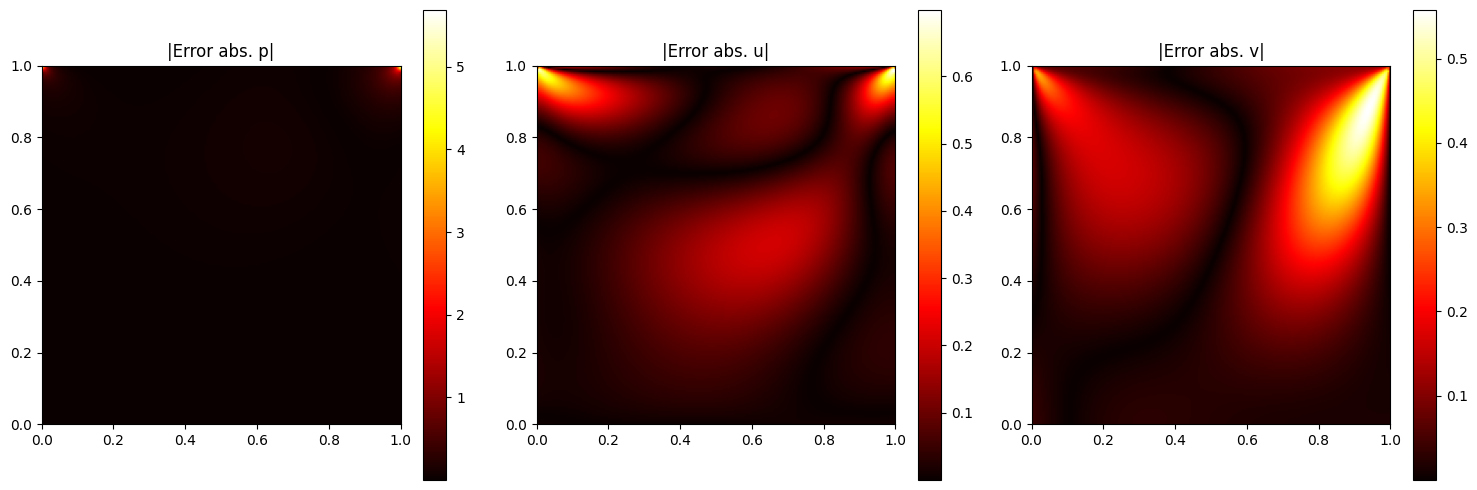

In [4]:
x_unique = np.linspace(x.min(), x.max(), 201)
y_unique = np.linspace(y.min(), y.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolaciones
P_true_grid = griddata((x, y), data_p.flatten(), (X_grid, Y_grid), method='cubic')
U_true_grid = griddata((x, y), data_u.flatten(), (X_grid, Y_grid), method='cubic')
V_true_grid = griddata((x, y), data_v.flatten(), (X_grid, Y_grid), method='cubic')

P_pred_grid = griddata((x, y), pred_p, (X_grid, Y_grid), method='cubic')
U_pred_grid = griddata((x, y), pred_u, (X_grid, Y_grid), method='cubic')
V_pred_grid = griddata((x, y), pred_v, (X_grid, Y_grid), method='cubic')

# Graficar errores absolutos
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (name, pred_g, true_g) in enumerate(zip(['p', 'u', 'v'], [P_pred_grid, U_pred_grid, V_pred_grid], [P_true_grid, U_true_grid, V_true_grid])):
    error_abs = np.abs(pred_g - true_g)
    im = axs[i].imshow(error_abs, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
    axs[i].set_title(f'|Error abs. {name}|')
    fig.colorbar(im, ax=axs[i])
plt.tight_layout()
plt.show()


## PUNTO 5


En base al grado de convergencia obtenido durante el entrenamiento y los gráficos de error, se puede considerar que el modelo desarrollado es suficientemente bueno para predecir los campos de presión y velocidad ya que alcanzó una pérdida del orden de 1e-7 y errores L2 bajos, lo que indica una buena aproximación de la solución del sistema. Como aspecto positivo, destaca la capacidad de la red para ajustarse adecuadamente a los datos y resolver el sistema de ecuaciones con alta precisión. No obstante, se observan fallas en las zonas cercanas a las fronteras, donde los errores son notablemente mayores, posiblemente debido a una cantidad insuficiente de puntos de colocación en esas regiones. En cuanto a los hiperparámetros utilizados, parecen ser adecuados dado el buen desempeño general del modelo; sin embargo, es posible mejorar aún más los resultados. Para ello, se podrían implementar acciones como aumentar la densidad de puntos en las fronteras, experimentar con arquitecturas más profundas o anchas, emplear estrategias adaptativas como el refinamiento basado en residuos (RAR), y aplicar técnicas de regularización o un ajuste más fino del *learning rate*. Estas mejoras podrían reducir los errores en las zonas críticas y aumentar la precisión general del modelo.


#TP3

## Paso 1 – Modularizar muestreo de puntos

In [5]:
!pip install pyDOE


  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=7f14f9e51c5cab71d6ff1b855a2df753d86203696653501597bb4529f249341d
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [6]:
from pyDOE import lhs

def sample_pde_points(strategy, Npde, model=None, domain=[[0, 1], [0, 1]], residuals=None):
    if strategy == 'uniform':
        return np.random.uniform(domain[0][0], domain[0][1], (Npde, 2))
    elif strategy == 'lhs':
        lhs_sample = lhs(2, samples=Npde)
        return lhs_sample * (np.array(domain)[:,1] - np.array(domain)[:,0]) + np.array(domain)[:,0]
    elif strategy == 'rad':
        assert model is not None and residuals is not None
        probs = residuals / np.sum(residuals)
        idx = np.random.choice(len(residuals), size=Npde, replace=False, p=probs)
        return residuals[idx, :2]  # asumiendo que residuals = [x, y, res]
    else:
        raise ValueError("Unknown sampling strategy")


## Paso 2 – RAD (residual-based adaptive sampling)

In [7]:
def compute_rad_residual_grid(model):
    # Crear una grilla de puntos (x, t)
    x = torch.linspace(0, 1, 100)
    t = torch.linspace(0, 1, 100)
    X, T = torch.meshgrid(x, t, indexing='ij')
    X = X.reshape(-1, 1)
    T = T.reshape(-1, 1)

    XT = torch.cat([X, T], dim=1).float()
    XT.requires_grad_(True)

    u = model(XT)

    # Derivadas
    grads = torch.autograd.grad(
        outputs=u,
        inputs=XT,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]

    u_x = grads[:, 0:1]
    u_t = grads[:, 1:2]

    # Aquí va el residuo de la PDE, por ejemplo para la ecuación de difusión:
    # u_t - alpha * u_xx = 0
    u_xx = torch.autograd.grad(
        outputs=u_x,
        inputs=XT,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True
    )[0][:, 0:1]

    alpha = 1.0  # o el coeficiente correspondiente
    residual = u_t - alpha * u_xx

    return residual.detach().cpu().numpy()


## Paso 3 – Correr los 9 experimentos

In [ ]:
configs = [
    ('uniform', 1000, 100),
    ('uniform', 10000, 1000),
    ('uniform', 100000, 10000),
    ('lhs', 1000, 100),
    ('lhs', 10000, 1000),
    ('lhs', 100000, 10000),
    ('rad', 1000, 100),
    ('rad', 10000, 1000),
    ('rad', 100000, 10000),
]

results = []

for strategy, Npde, Nbc in configs:
    print(f"\n Running: strategy={strategy}, Npde={Npde}, Nbc={Nbc}")

    # Si RAD, entrenar modelo inicial + obtener residuos
    if strategy == 'rad':
        model_pre = PINN_NavierStokes().to(device)
        init_xavier(model_pre)
        optimizer = torch.optim.Adam(model_pre.parameters(), lr=1e-4)


        X_pde = sample_pde_points('uniform', Npde)
        X_pde_torch = torch.tensor(X_pde, dtype=torch.float32, requires_grad=True).to(device)

        for _ in range(3000):  # entrenamiento corto
            optimizer.zero_grad()
            r1, r2, r3 = compute_residuals(model_pre, X_pde_torch)
            loss_pde = loss_fn(r1, torch.zeros_like(r1)) + loss_fn(r2, torch.zeros_like(r2)) + loss_fn(r3, torch.zeros_like(r3))
            loss_pde.backward()
            optimizer.step()

        rad_residuals = compute_rad_residual_grid(model_pre)
        X_pde = sample_pde_points('rad', Npde, model_pre, residuals=rad_residuals)
    else:
        X_pde = sample_pde_points(strategy, Npde)

    X_pde_torch = torch.tensor(X_pde, dtype=torch.float32, requires_grad=True).to(device)


    model = PINN_NavierStokes().to(device)
    init_xavier(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_history = []

    for epoch in range(10000):
        optimizer.zero_grad()
        r1, r2, r3 = compute_residuals(model, X_pde_torch)
        loss_r1 = loss_fn(r1, torch.zeros_like(r1))
        loss_r2 = loss_fn(r2, torch.zeros_like(r2))
        loss_r3 = loss_fn(r3, torch.zeros_like(r3))
        loss_pde = loss_r1 + loss_r2 + loss_r3

        bc_pred = model(X_bc_torch)
        loss_bc = loss_fn(bc_pred[:, 1:2], y_bc_u) + loss_fn(bc_pred[:, 2:3], y_bc_v)

        x_p0 = torch.tensor([[0.0, 0.0]], dtype=torch.float32).to(device)
        p0_pred = model(x_p0)[:, 0:1]
        loss_p = 1e3 * loss_fn(p0_pred, torch.zeros_like(p0_pred))

        loss = loss_pde + 10 * loss_bc + loss_p
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    # --- Evaluación ---
    with torch.no_grad():
        xy_eval_tensor = torch.tensor(xy_eval, dtype=torch.float32).to(device)
        pred = model(xy_eval_tensor).cpu().numpy()
    pred_p = pred[:, 0]
    pred_u = pred[:, 1]
    pred_v = pred[:, 2]

    err_p = np.linalg.norm(pred_p - data_p.flatten()) / np.linalg.norm(data_p)
    err_u = np.linalg.norm(pred_u - data_u.flatten()) / np.linalg.norm(data_u)
    err_v = np.linalg.norm(pred_v - data_v.flatten()) / np.linalg.norm(data_v)

    results.append((strategy, Npde, Nbc, err_p, err_u, err_v))



 Running: strategy=uniform, Npde=1000, Nbc=100

 Running: strategy=uniform, Npde=10000, Nbc=1000


## Paso 4 – Graficar convergencia

In [ ]:
import pandas as pd

df = pd.DataFrame(results, columns=['strategy', 'Npde', 'Nbc', 'err_p', 'err_u', 'err_v'])

for var in ['err_p', 'err_u', 'err_v']:
    plt.figure()
    for strategy in ['uniform', 'lhs', 'rad']:
        subset = df[df.strategy == strategy]
        plt.loglog(subset['Npde'], subset[var], label=strategy)
    plt.xlabel('Npde')
    plt.ylabel(f'Error L2 - {var[-1]}')
    plt.title(f'Convergencia {var}')
    plt.legend()
    plt.grid(True)
    plt.show()
